# Diversified vs. Tech Portfolio Analysis

## Project Setup

This notebook requires several Python libraries. They can be installed via:
```bash
pip install -r requirements.txt
```
Helper functions are imported from 'utils.py'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import scipy.stats as stats
import os

from utils import get_data, quarterly_rebalancing, downside_deviation


plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
%config InlineBackend.figure_format = 'retina'

In [3]:
tickers = ['XLK', 'SPY', 'XLF', 'XLE', 'XLV', 'XLI', 'XLP', 'XLU']
start_date = '2014-01-01'
end_date = '2024-12-31'
prices_df = get_data(tickers, start_date, end_date)
prices_df.head()

Loading data from local file...


,SPY,XLE,XLF,XLI,XLK,XLP,XLU,XLV
Date,,,,,,,,
2014-01-02,149.840530,56.203926,14.236197,41.767387,30.573997,31.333782,25.677317,45.763630
2014-01-03,149.815994,55.997787,14.334420,41.880863,30.427132,31.274738,25.594910,45.871532
2014-01-06,149.381851,56.075111,14.347518,41.637684,30.375305,31.156631,25.636116,45.680614
2014-01-07,150.299271,56.500244,14.354069,41.897072,30.651747,31.326403,25.862732,46.162067
2014-01-08,150.332031,56.107292,14.399901,41.824120,30.651747,31.090199,25.725388,46.568813


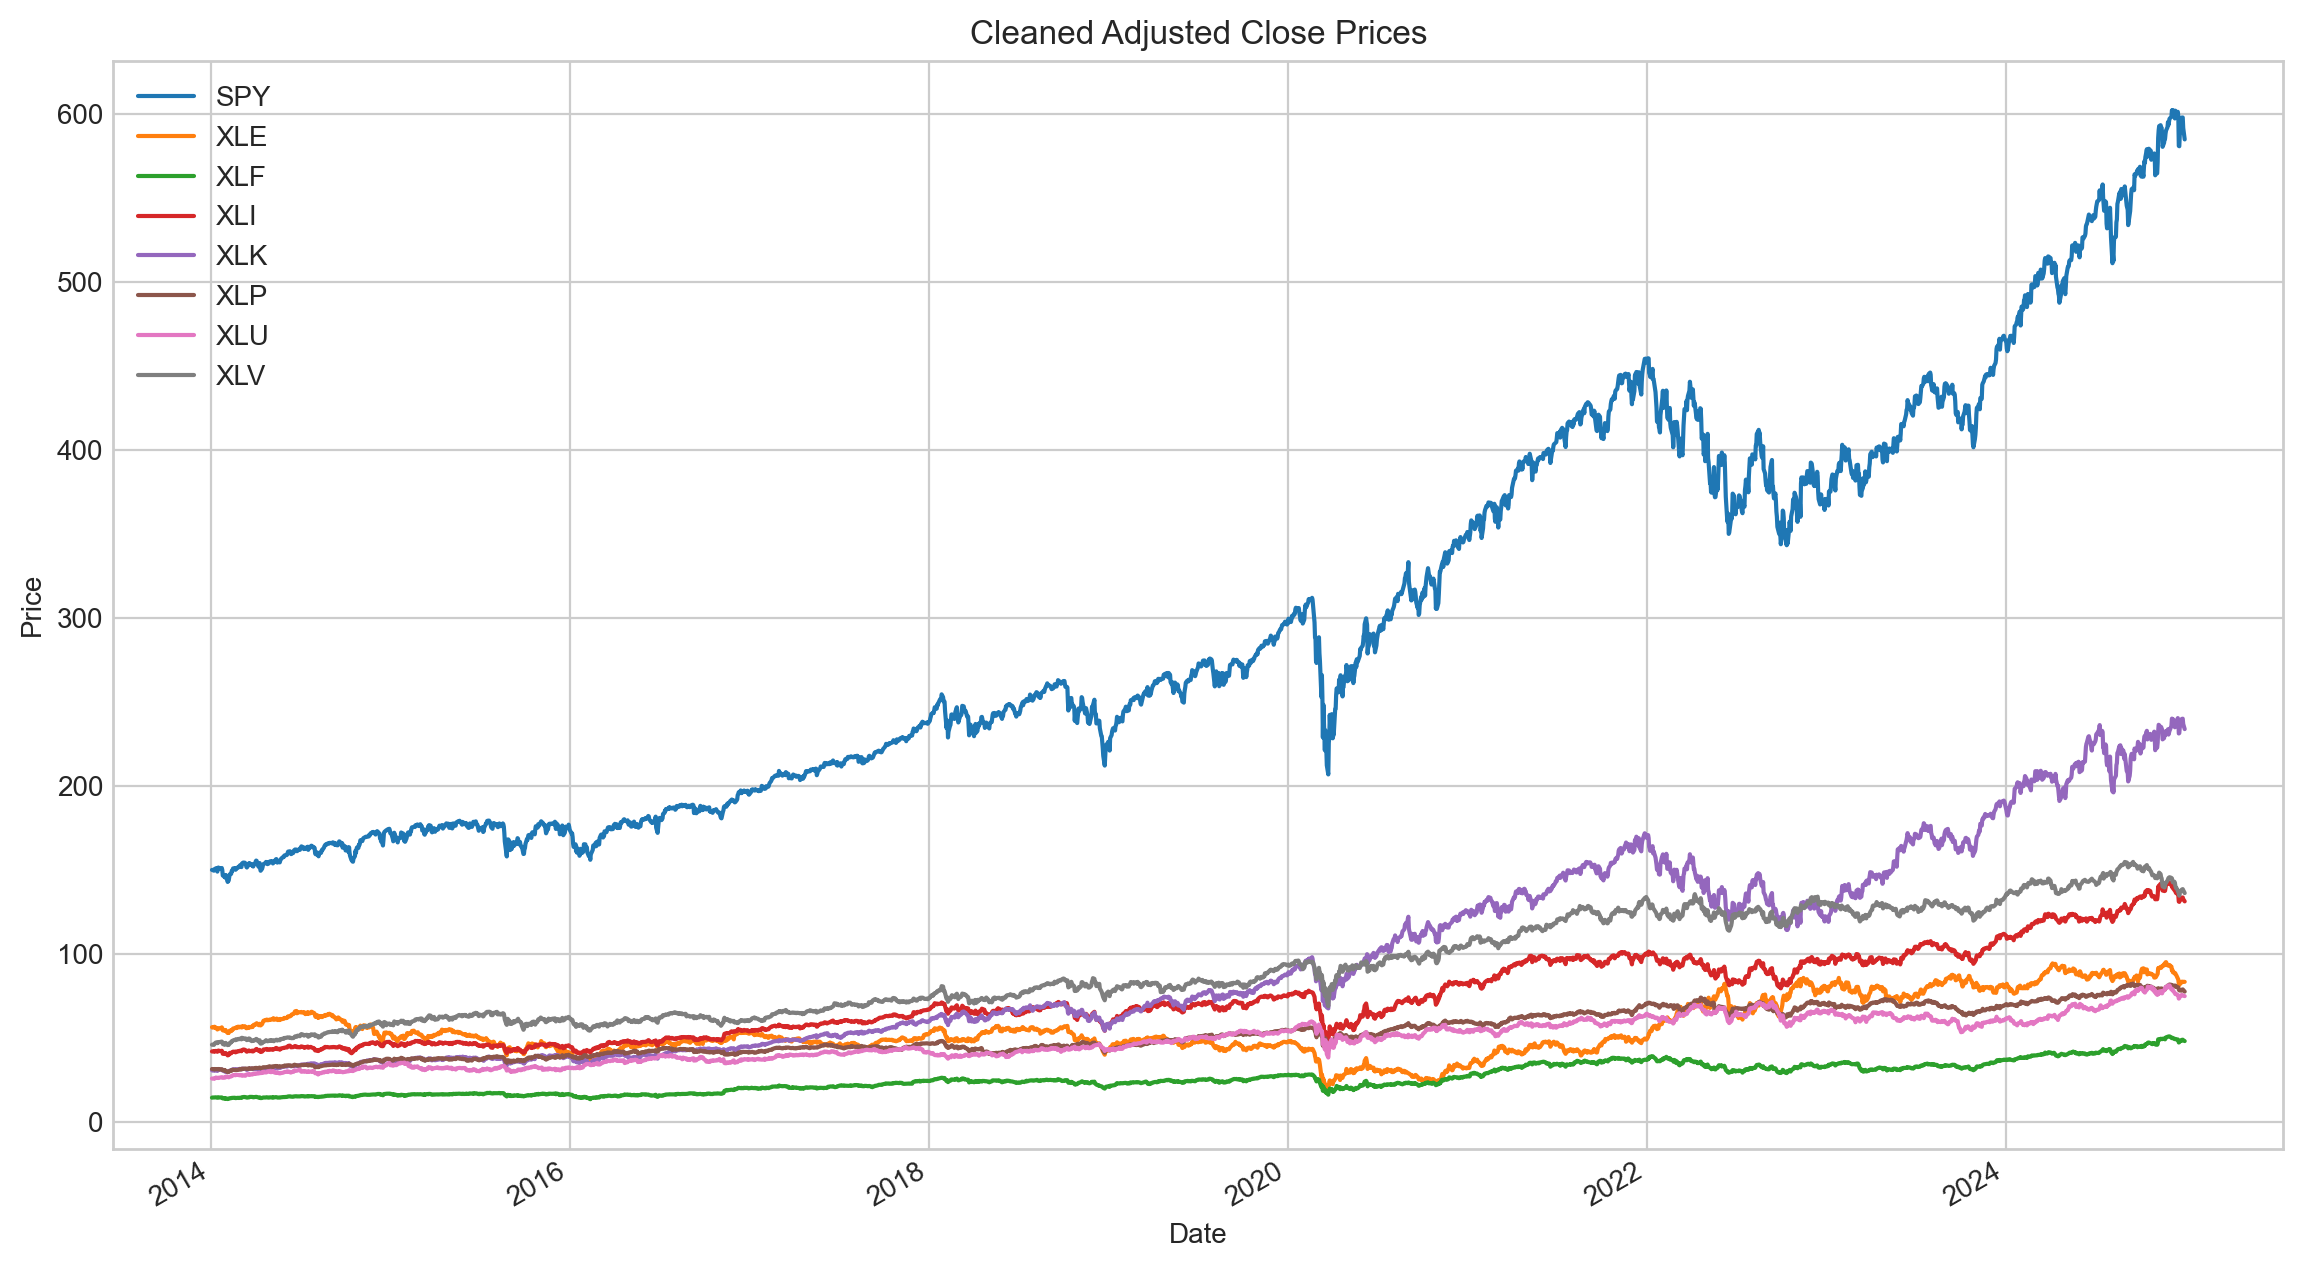

In [4]:
#Plot the data quickly to check for any outstanding issues:
prices_df.plot(title = 'Cleaned Adjusted Close Prices', figsize = (14, 8))
plt.ylabel('Price');

C:\Users\Dell\Projects\Finance\Diversified_vs_tech_portfolio\utils.py:48: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  div_returns = div_equity.pct_change().fillna(0).astype(float) #this is so taht pandas knows in the future the data type, cause it will turn off automatic recognition for .fillna function


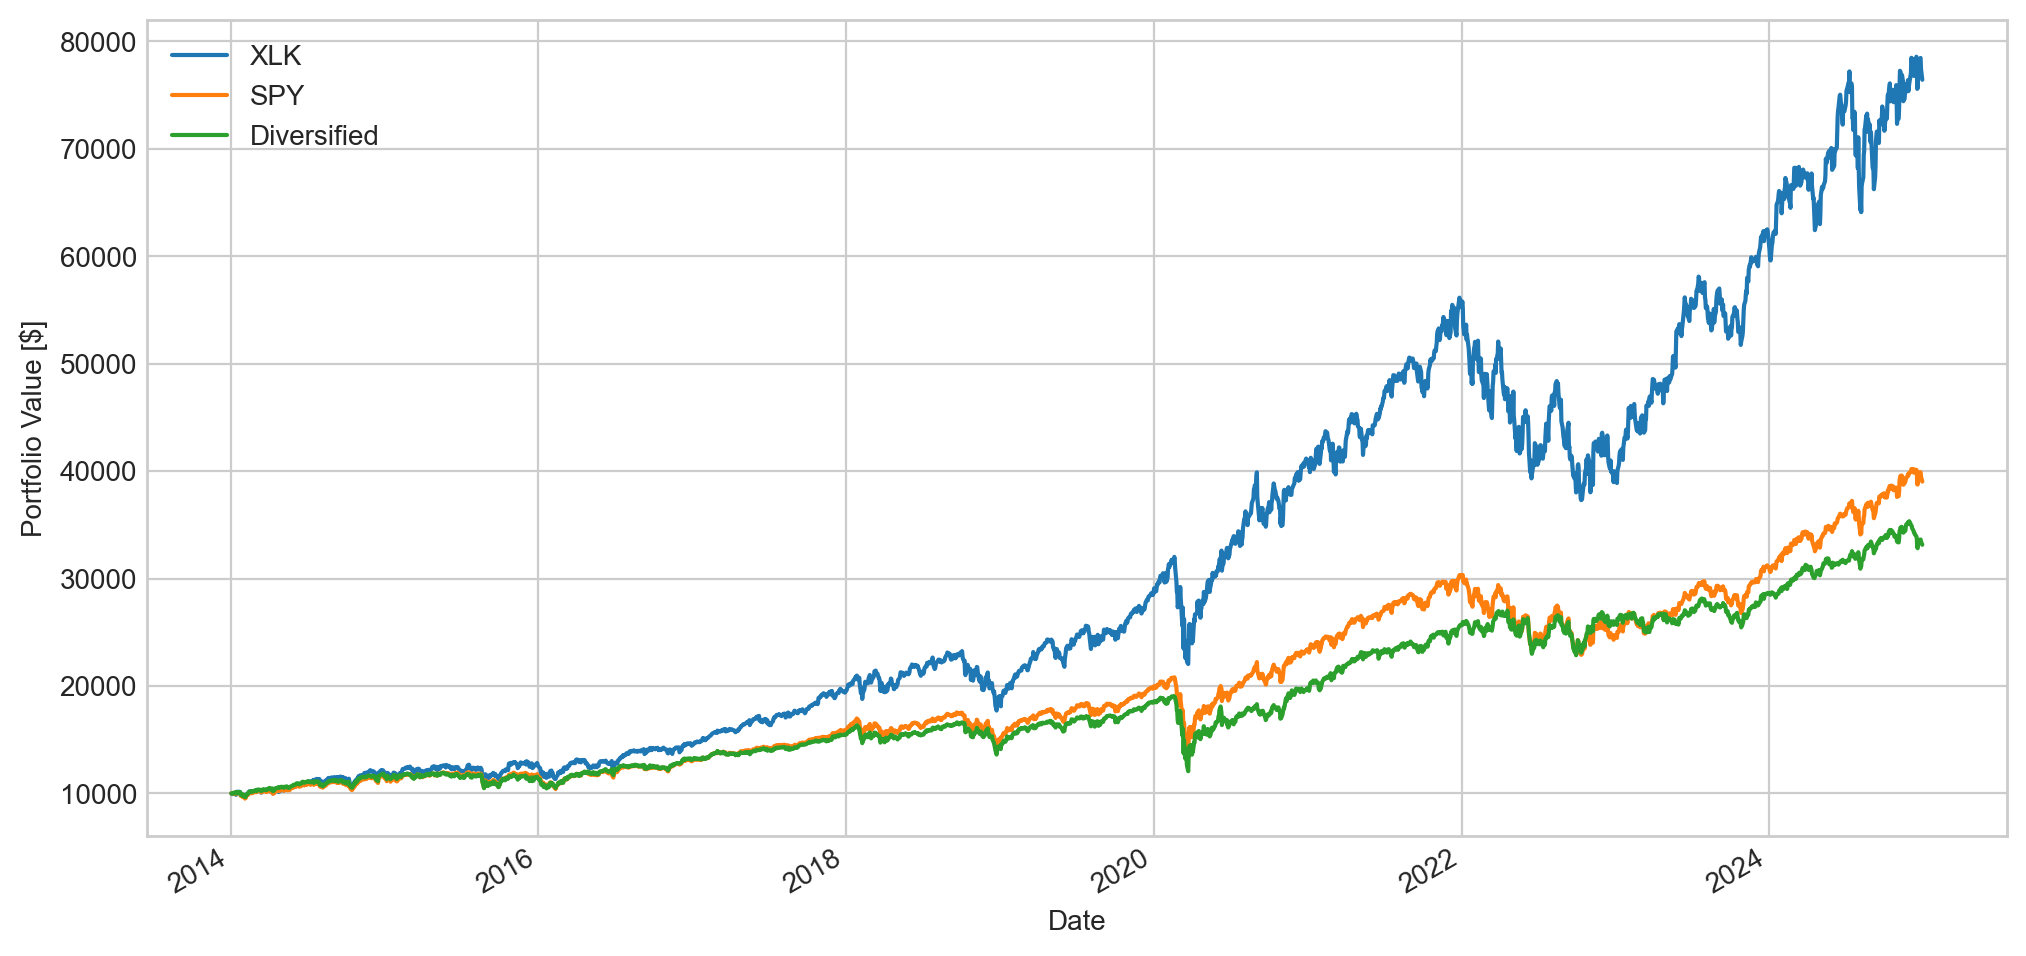

In [5]:
returns_df = prices_df.pct_change() #daily returns for each ETF
returns_df.iloc[0] = 0 #without this first row of .pct_change() would be NaN resulting in issues later
initial_capital = 10000

tech_returns = returns_df['XLK']
tech_equity = (1 + tech_returns).cumprod()
tech_equity *= initial_capital
tech_equity.plot()

bench_returns = returns_df['SPY']
bench_equity = (1 + bench_returns).cumprod()
bench_equity *= initial_capital
bench_equity.plot()

div_tickers = [i for i in tickers if i != 'SPY'] #create portfolio of remaining tickers
target_weights = np.array([1/len(div_tickers)] * len(div_tickers))
div_equity, div_returns = quarterly_rebalancing(returns_df, div_tickers, target_weights, initial_capital)

div_equity.plot(label = 'Diversified')
plt.ylabel('Portfolio Value [$]')
plt.legend();

In [6]:
#Compound Annual Growth Rates calculations:
tech_cagr_pct = (tech_equity.iloc[-1]/initial_capital)**(1/10) - 1
bench_cagr_pct = (bench_equity.iloc[-1]/initial_capital)**(1/10) - 1
div_cagr_pct = (div_equity.iloc[-1]/initial_capital)**(1/10) - 1
print(f'CAGR for tech only (XLK) porfolio: {tech_cagr_pct:.2%} \nCAGR for benchmark S&P500 porfolio: {bench_cagr_pct:.2%} \nCAGR for diversified porfolio: {div_cagr_pct:.2%}')

CAGR for tech only (XLK) porfolio: 22.55% 
CAGR for benchmark S&P500 porfolio: 14.59% 
CAGR for diversified porfolio: 12.73%


In [7]:
#returns volatility calculations:
tech_daily_volatility = tech_returns.std()
bench_daily_volatility = bench_returns.std()
div_daily_volatility = div_returns.std()

tech_annual_volatility = tech_daily_volatility * np.sqrt(252) #252 trading days in a year on average
bench_annual_volatility = bench_daily_volatility * np.sqrt(252)
div_annual_volatility = div_daily_volatility * np.sqrt(252)

print(f'Annual volatility for tech only (XLK) portfolio: {tech_annual_volatility:.2} \nAnnual volatility for benchmark S&P500 portfolio: {bench_annual_volatility:.2} \nAnnual volatility for diversified portfolio: {div_annual_volatility:.2}')

Annual volatility for tech only (XLK) portfolio: 0.23 
Annual volatility for benchmark S&P500 portfolio: 0.17 
Annual volatility for diversified portfolio: 0.16


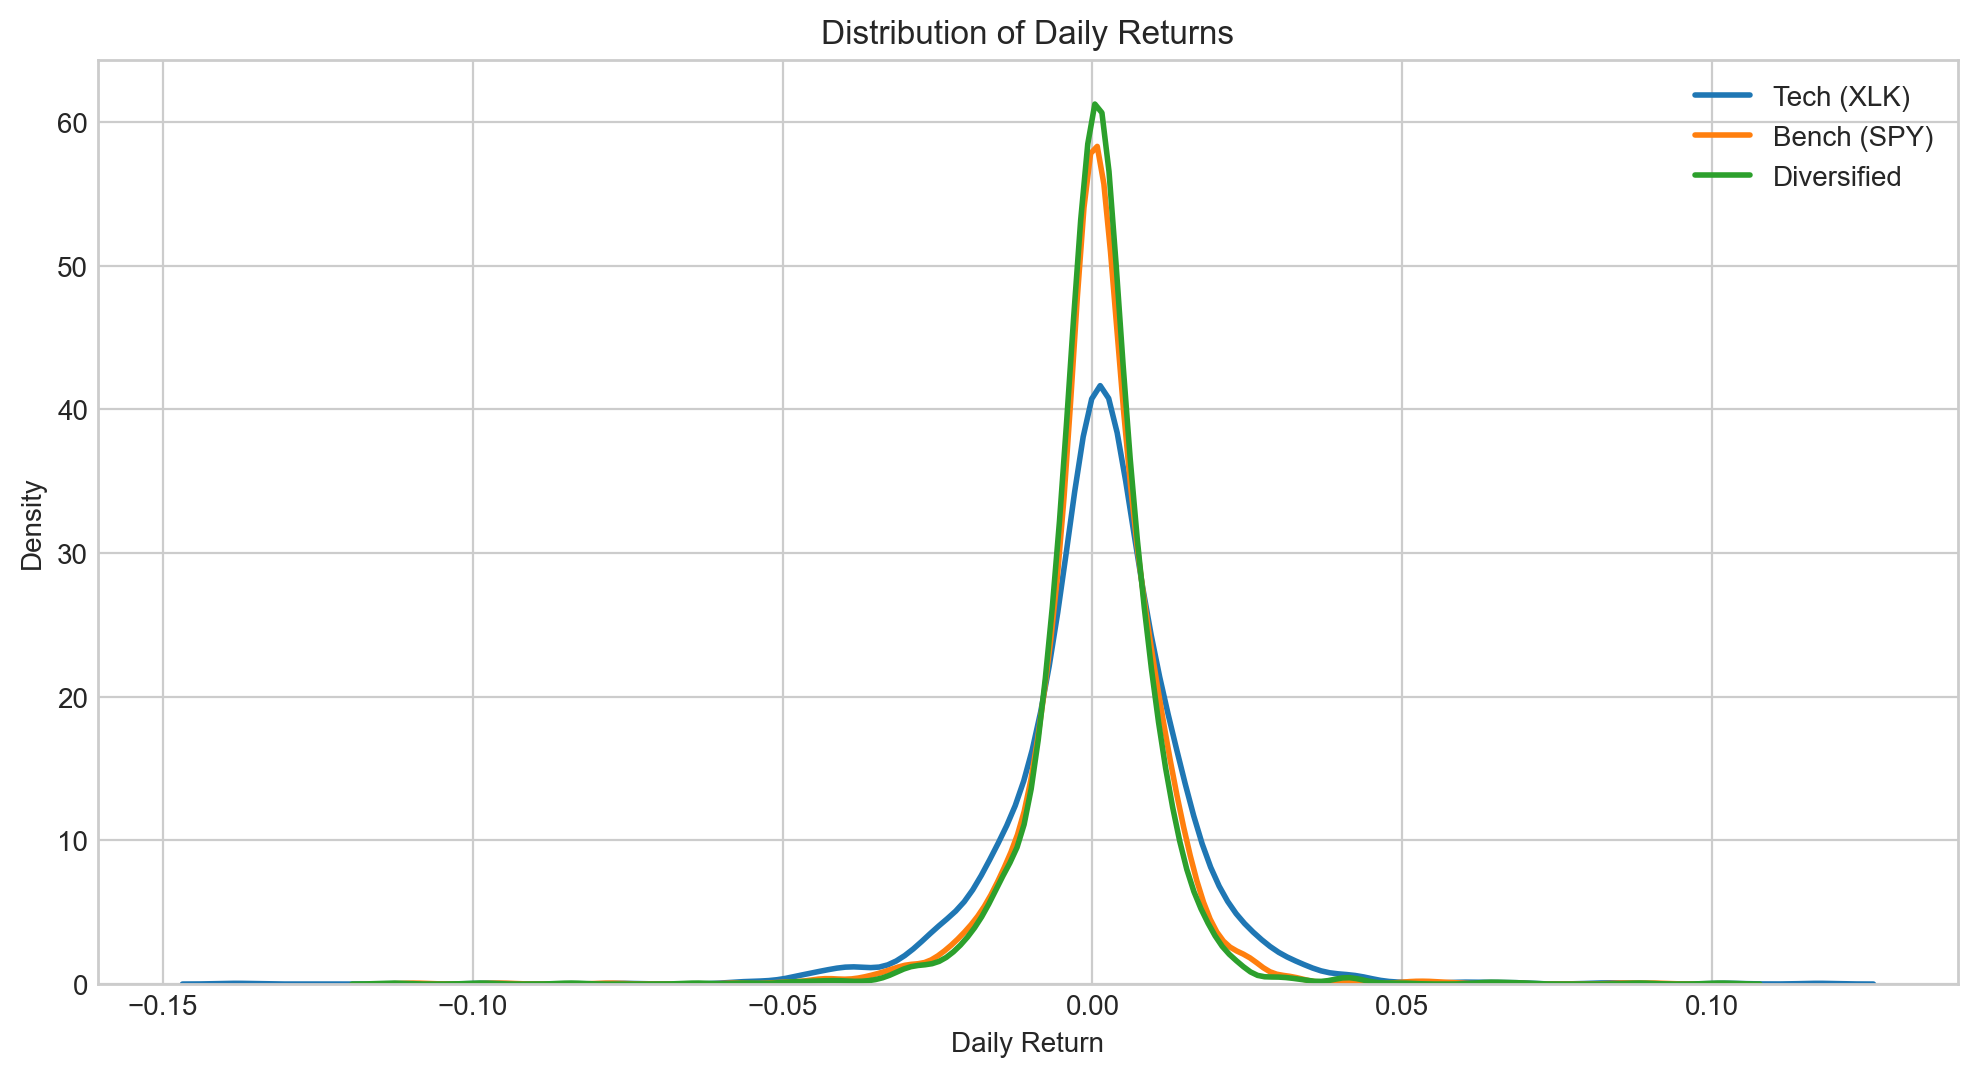

In [8]:
sns.kdeplot(tech_returns, label='Tech (XLK)', linewidth = 2)
sns.kdeplot(bench_returns, label='Bench (SPY)', linewidth = 2)
sns.kdeplot(div_returns, label='Diversified', linewidth = 2)

plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Density')
plt.legend()
plt.show()

In [9]:
#Maximum Drawdown calculations:
tech_equity_runnimg_max = tech_equity.cummax()
tech_dd_series = (tech_equity/tech_equity_runnimg_max) - 1
tech_max_dd = tech_dd_series.min()

bench_equity_runnimg_max = bench_equity.cummax()
bench_dd_series = (bench_equity/bench_equity_runnimg_max) - 1
bench_max_dd = bench_dd_series.min()

div_equity_runnimg_max = div_equity.cummax()
div_dd_series = (div_equity/div_equity_runnimg_max) - 1
div_max_dd = div_dd_series.min()

print(f'Maximum Drawdown for tech only (XLK) porfolio: {tech_max_dd:.2%}\nMaximum Drawdown for benchmark S&P500 porfolio: {bench_max_dd:.2%}\nMaximum Drawdown for diversified porfolio: {div_max_dd:.2%}')

Maximum Drawdown for tech only (XLK) porfolio: -33.56%
Maximum Drawdown for benchmark S&P500 porfolio: -33.72%
Maximum Drawdown for diversified porfolio: -36.62%


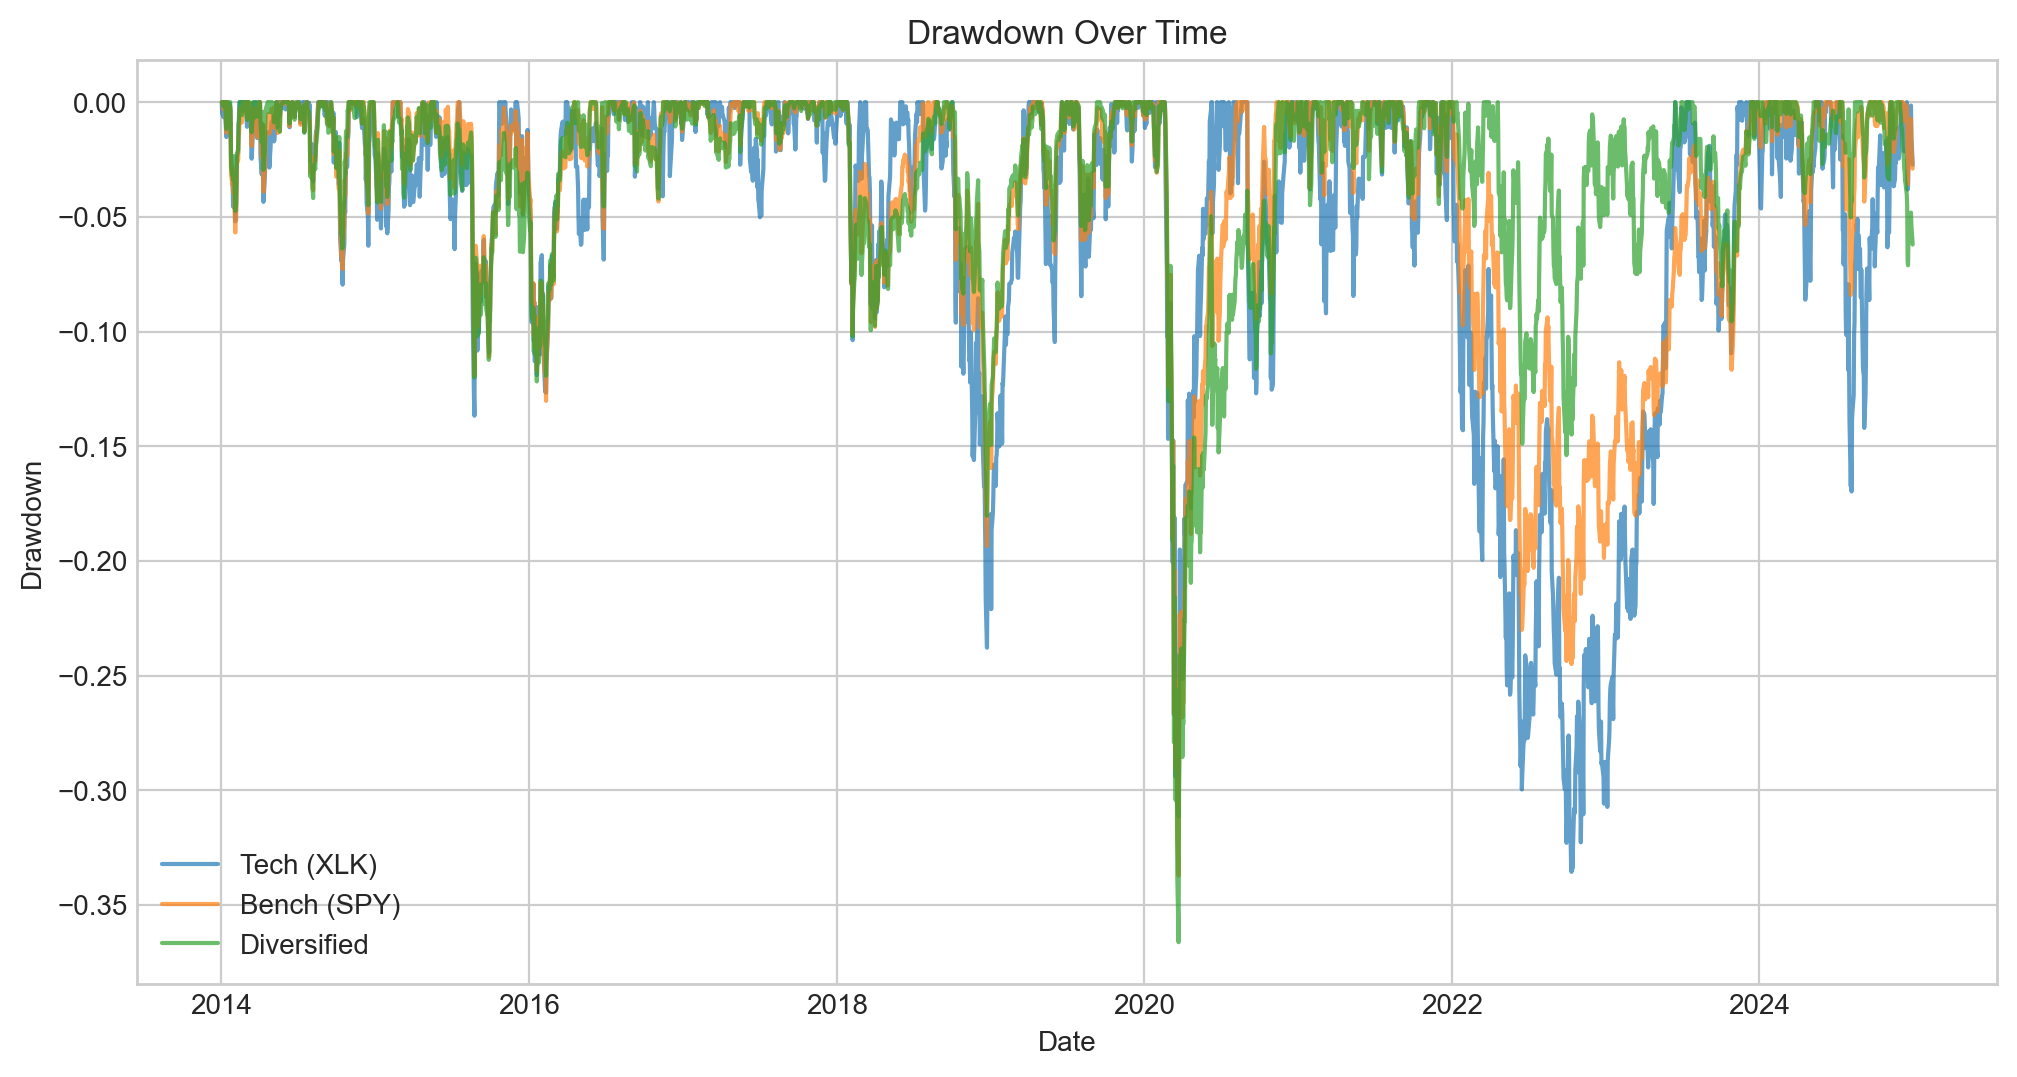

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(tech_dd_series, label='Tech (XLK)', alpha=0.7)
plt.plot(bench_dd_series, label='Bench (SPY)', alpha=0.7)
plt.plot(div_dd_series, label='Diversified', alpha=0.7)

plt.title('Drawdown Over Time')
plt.ylabel('Drawdown')
plt.xlabel('Date')
plt.legend()
plt.show()

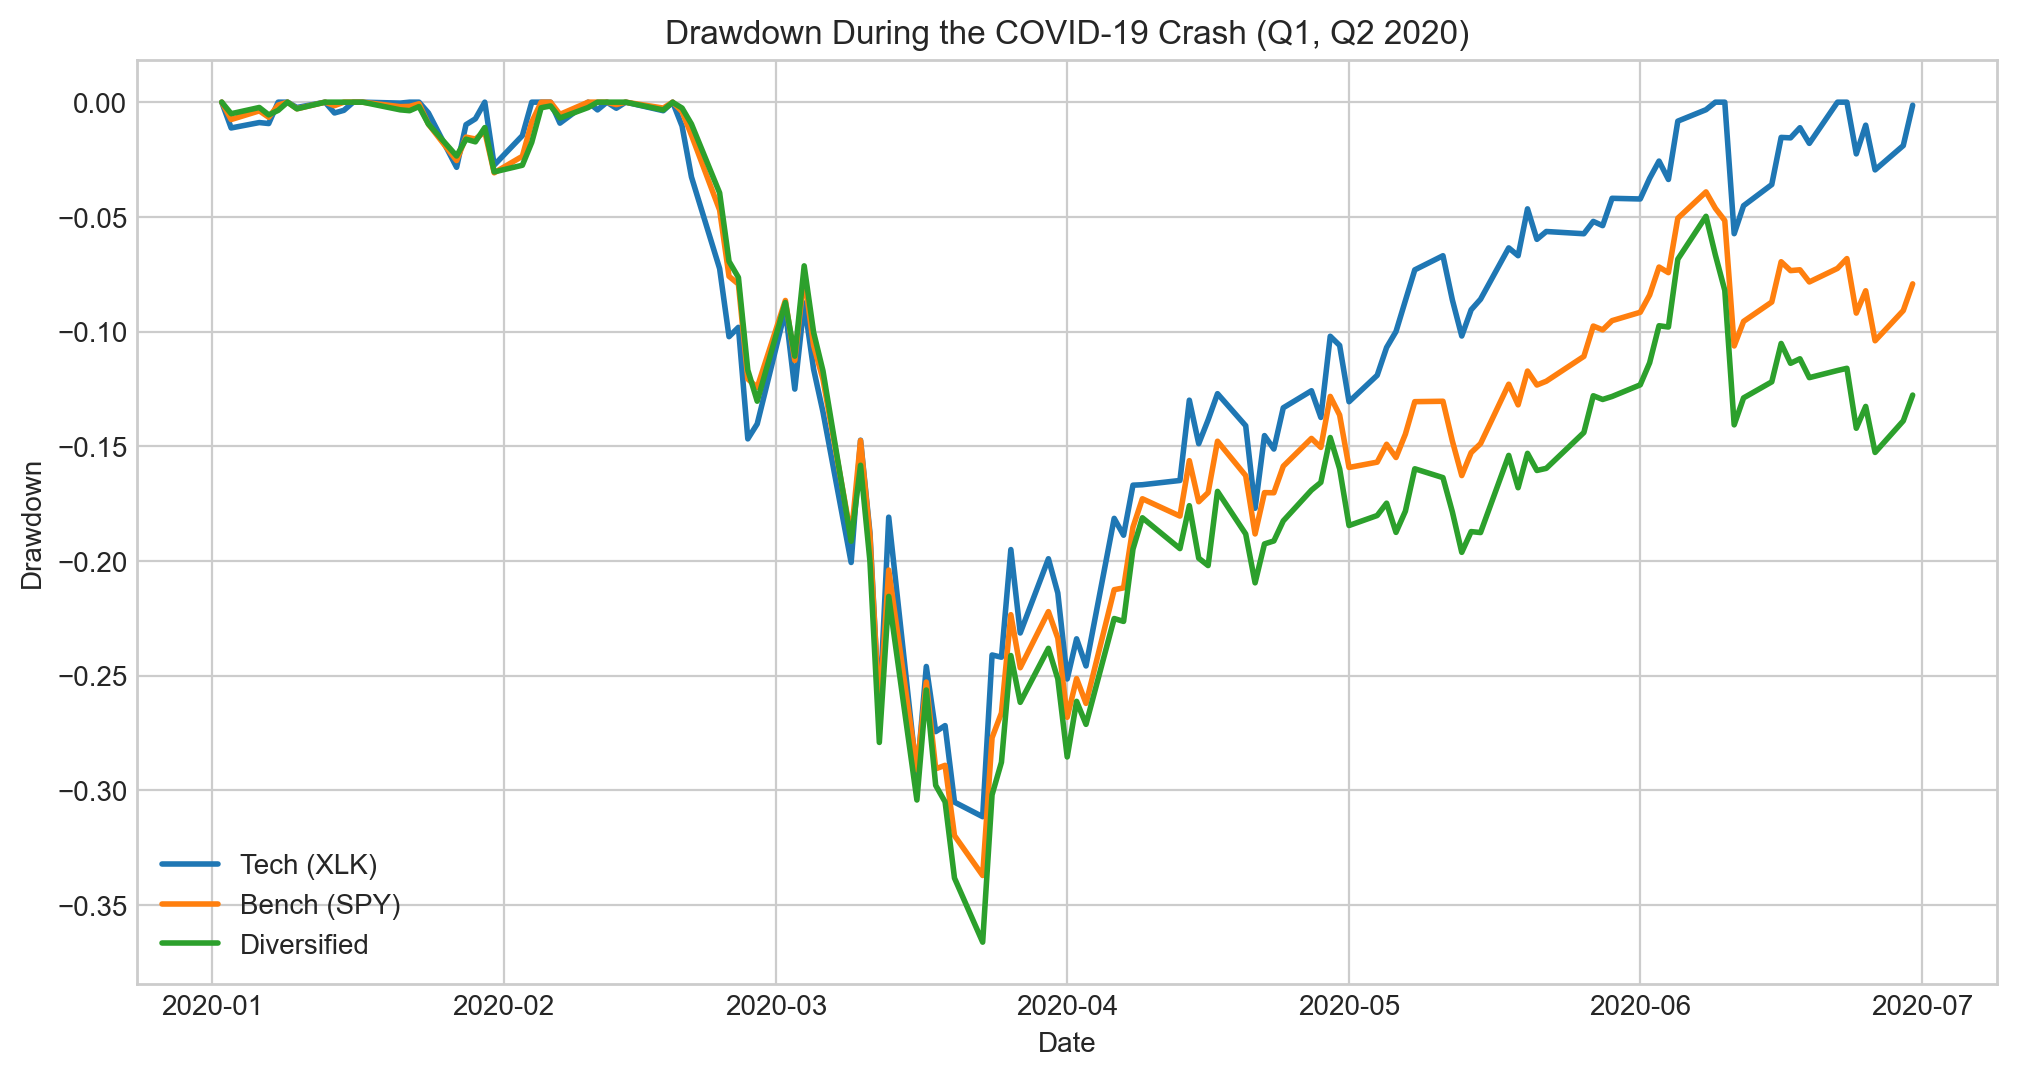

In [11]:
drawdown_series = pd.DataFrame({
    'tech_dd': tech_dd_series,
    'bench_dd': bench_dd_series,
    'div_dd': div_dd_series
})

mask_h1_2020 = (drawdown_series.index >= '2020-01-01') & (drawdown_series.index < '2020-07-01') #mask for the first half of 2020
dd_h1_2020 = drawdown_series.loc[mask_h1_2020]

plt.plot(dd_h1_2020['tech_dd'], label='Tech (XLK)', linewidth=2)
plt.plot(dd_h1_2020['bench_dd'], label='Bench (SPY)', linewidth=2)
plt.plot(dd_h1_2020['div_dd'], label='Diversified', linewidth=2)

plt.title('Drawdown During the COVID-19 Crash (Q1, Q2 2020)')
plt.ylabel('Drawdown')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

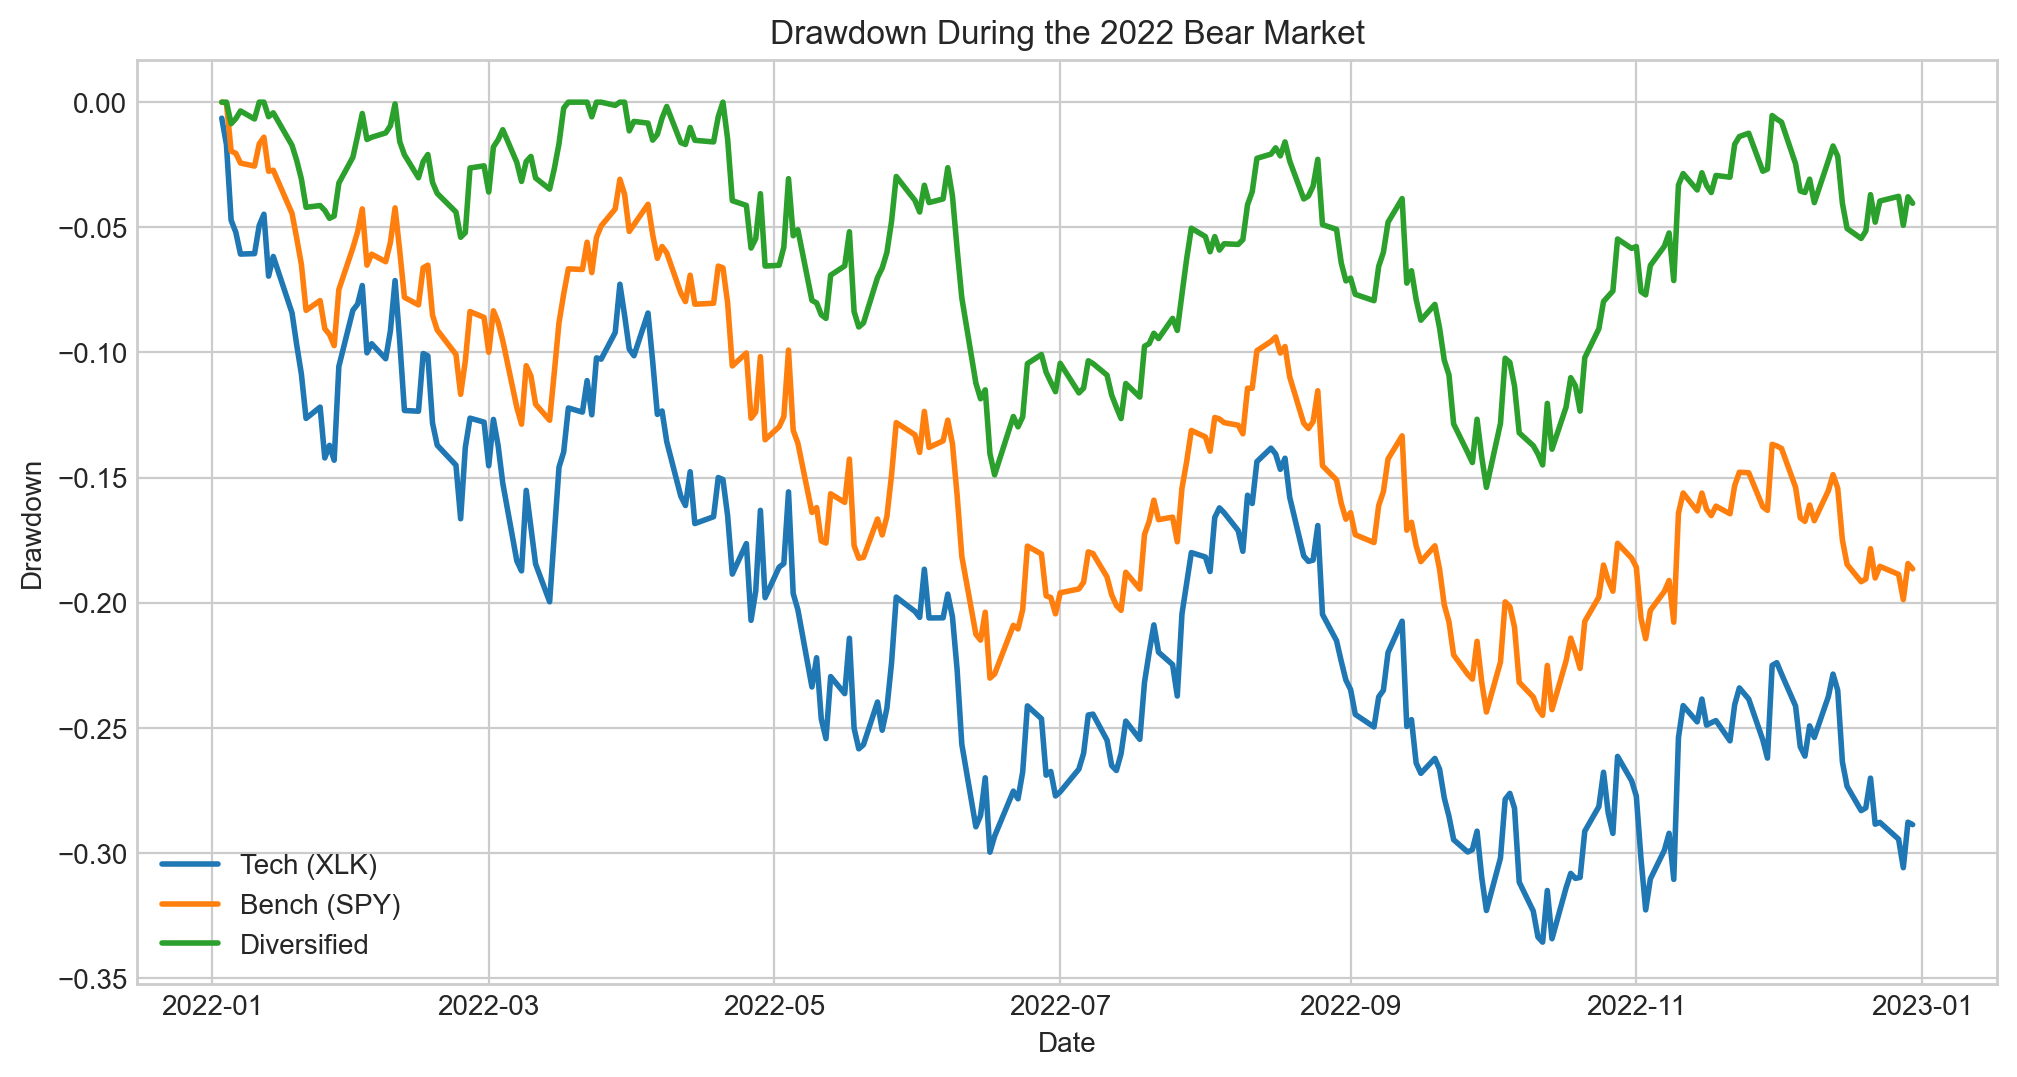

In [12]:
mask_2022 = (drawdown_series.index >= '2022-01-01') & (drawdown_series.index < '2023-01-01') #mask to filter for dates in 2022
dd_2022 = drawdown_series.loc[mask_2022]

plt.plot(dd_2022['tech_dd'], label='Tech (XLK)', linewidth=2)
plt.plot(dd_2022['bench_dd'], label='Bench (SPY)', linewidth=2)
plt.plot(dd_2022['div_dd'], label='Diversified', linewidth=2)

plt.title('Drawdown During the 2022 Bear Market')
plt.ylabel('Drawdown')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
#Sharpe Ratio calculations:
tech_annualized_return = (1 + tech_returns.mean())**252 - 1 #geometric annualized portfolio return for Sharpe Ratio calc
bench_annualized_return = (1 + bench_returns.mean())**252 - 1
div_annualized_return = (1 + div_returns.mean())**252 - 1

print(f'Average annual return on tech only (XLK) portfolio: {tech_annualized_return:.2%} \nAverage annual return on benchmark (SPY) portfolio: {bench_annualized_return:.2%} \nAverage annual return on diversified portfolio: {div_annualized_return:.2%}')

Average annual return on tech only (XLK) portfolio: 23.45% 
Average annual return on benchmark (SPY) portfolio: 14.88% 
Average annual return on diversified portfolio: 13.04%


In [14]:
#10-year US treasury bond daily rate download
TNX = yf.download('^TNX', start = start_date, end = end_date)['Close']
TNX = TNX.sort_index()
TNX.head()

C:\Users\Dell\AppData\Local\Temp\ipykernel_14012\3709823452.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  TNX = yf.download('^TNX', start = start_date, end = end_date)['Close']
[*********************100%***********************]  1 of 1 completed


Ticker,^TNX
Date,
2014-01-02,2.985
2014-01-03,2.995
2014-01-06,2.961
2014-01-07,2.937
2014-01-08,2.993


In [15]:
#Sharpe Ratio calculations continued:
average_tnx_yield = TNX.mean().iloc[0]/100

tech_sharpe = (tech_annualized_return - average_tnx_yield)/tech_annual_volatility
bench_sharpe = (bench_annualized_return - average_tnx_yield)/bench_annual_volatility
div_sharpe = (div_annualized_return - average_tnx_yield)/div_annual_volatility

print(f'Sharpe Ratio for tech only (XLK) portfolio: {tech_sharpe:.2} \nSharpe Ratio for benchmark (SPY) portfolio: {bench_sharpe:.2} \nSharpe Ratio for diversified portfolio: {div_sharpe:.2}')

Sharpe Ratio for tech only (XLK) portfolio: 0.93 
Sharpe Ratio for benchmark (SPY) portfolio: 0.72 
Sharpe Ratio for diversified portfolio: 0.65


In [16]:
#Sortino Ratio calculations:
MAR = average_tnx_yield #define minimum acceptable return, decimal
tech_excess_returns = tech_returns - MAR
bench_excess_returns = bench_returns - MAR
div_excess_returns = div_returns - MAR

tech_downside_returns = tech_excess_returns[tech_excess_returns < 0]
bench_downside_returns = bench_excess_returns[bench_excess_returns < 0]
div_downside_returns = div_excess_returns[div_excess_returns < 0]

tech_downside_deviation_annualized = tech_downside_returns.std() * np.sqrt(252)
bench_downside_deviation_annualized = bench_downside_returns.std() * np.sqrt(252)
div_downside_deviation_annualized = div_downside_returns.std() * np.sqrt(252)

tech_sortino = (tech_annualized_return - average_tnx_yield)/tech_downside_deviation_annualized
bench_sortino = (bench_annualized_return - average_tnx_yield)/bench_downside_deviation_annualized
div_sortino = (div_annualized_return - average_tnx_yield)/div_downside_deviation_annualized

print(f'Sortino Ratio for tech only (XLK) portfolio: {tech_sortino:.2} \nSortino Ratio for benchmark (SPY) portfolio: {bench_sortino:.2} \nSortino Ratio for diversified portfolio: {div_sortino:.2}')

Sortino Ratio for tech only (XLK) portfolio: 1.1 
Sortino Ratio for benchmark (SPY) portfolio: 0.79 
Sortino Ratio for diversified portfolio: 0.72


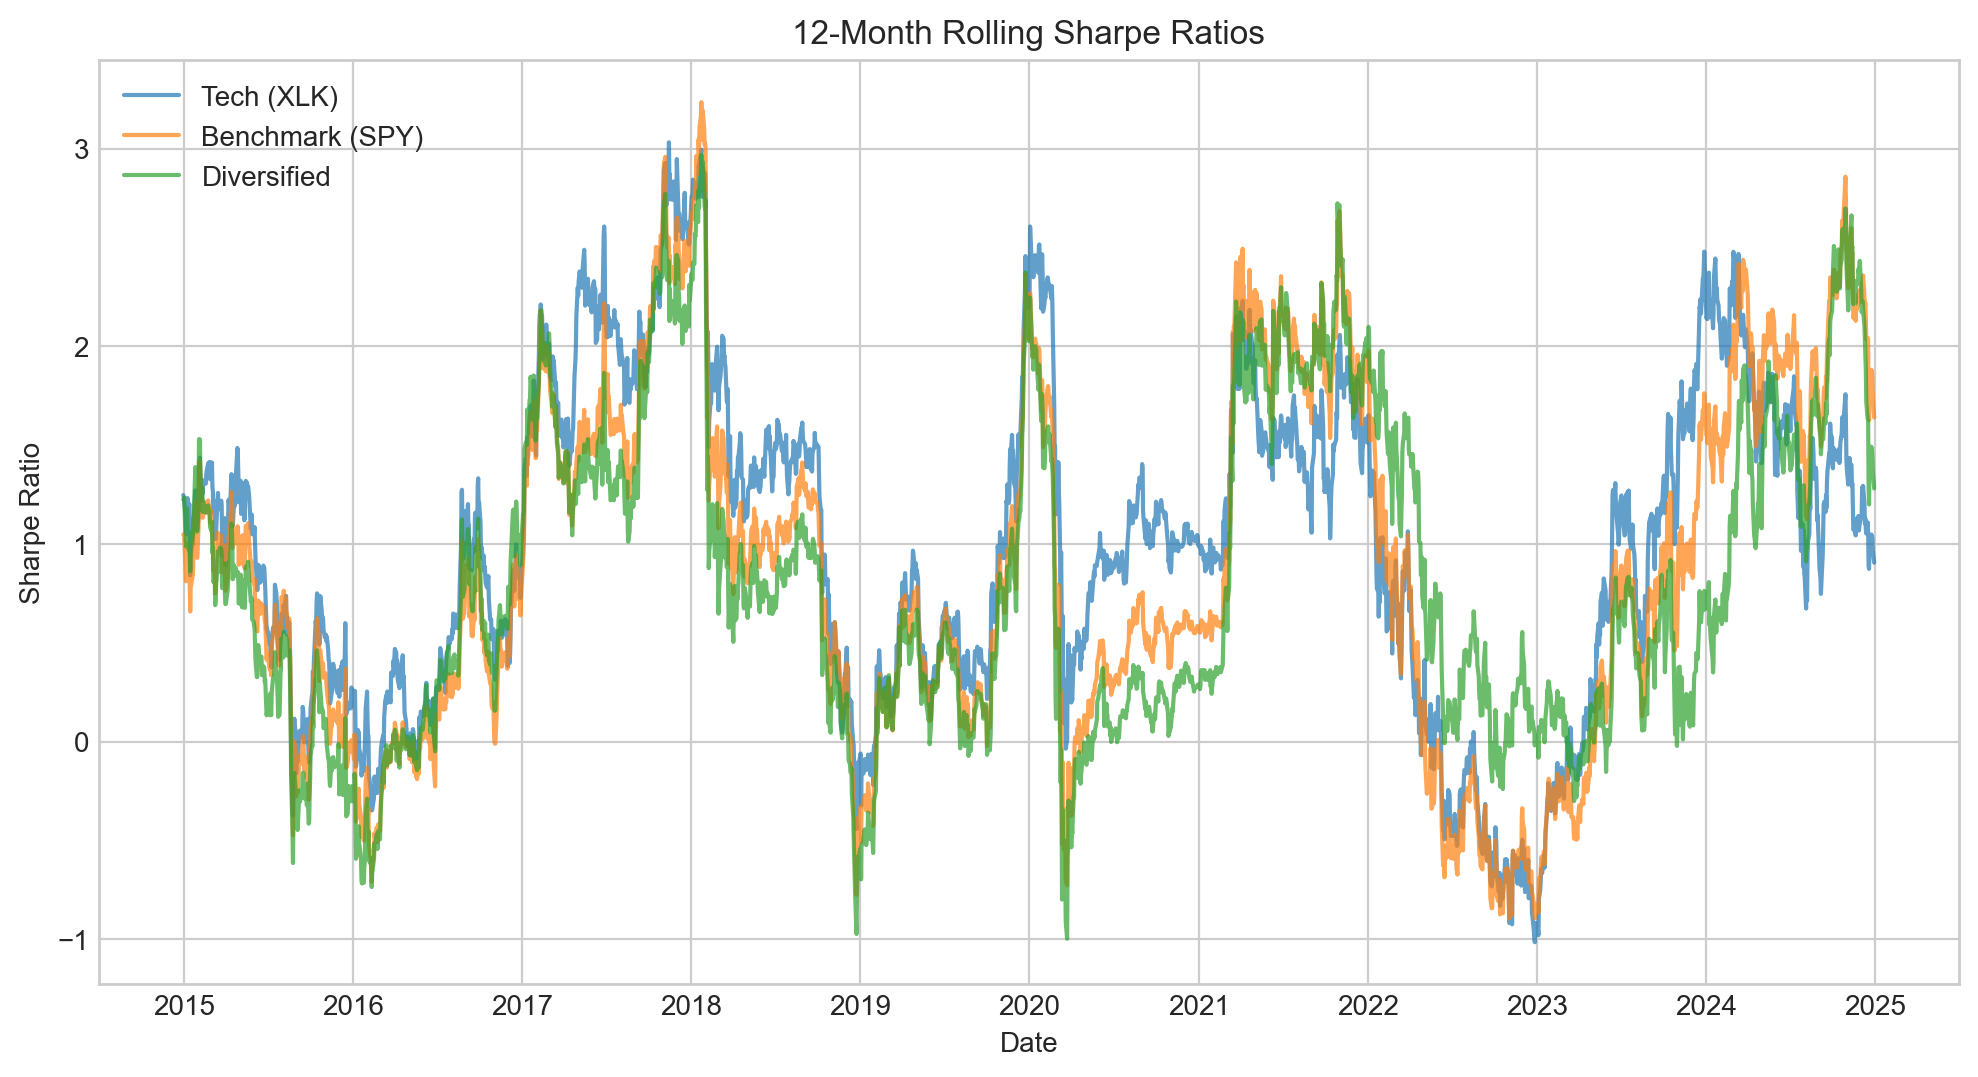

In [17]:
#rolling Sharpe Ratios calculations
tech_rolling_returns = tech_returns.rolling(window = 252)
bench_rolling_returns = bench_returns.rolling(window = 252)
div_rolling_returns = div_returns.rolling(window = 252)

tech_rolling_sharpe = (tech_rolling_returns.mean()*252 - average_tnx_yield)/(tech_rolling_returns.std()*np.sqrt(252))
bench_rolling_sharpe = (bench_rolling_returns.mean()*252 - average_tnx_yield)/(bench_rolling_returns.std()*np.sqrt(252))
div_rolling_sharpe = (div_rolling_returns.mean()*252 - average_tnx_yield)/(div_rolling_returns.std()*np.sqrt(252))

plt.plot(tech_rolling_sharpe, label='Tech (XLK)', alpha=0.7)
plt.plot(bench_rolling_sharpe, label='Benchmark (SPY)', alpha=0.7)
plt.plot(div_rolling_sharpe, label='Diversified', alpha=0.7)
plt.title('12-Month Rolling Sharpe Ratios')
plt.ylabel('Sharpe Ratio')
plt.xlabel('Date')
plt.legend()
plt.show()

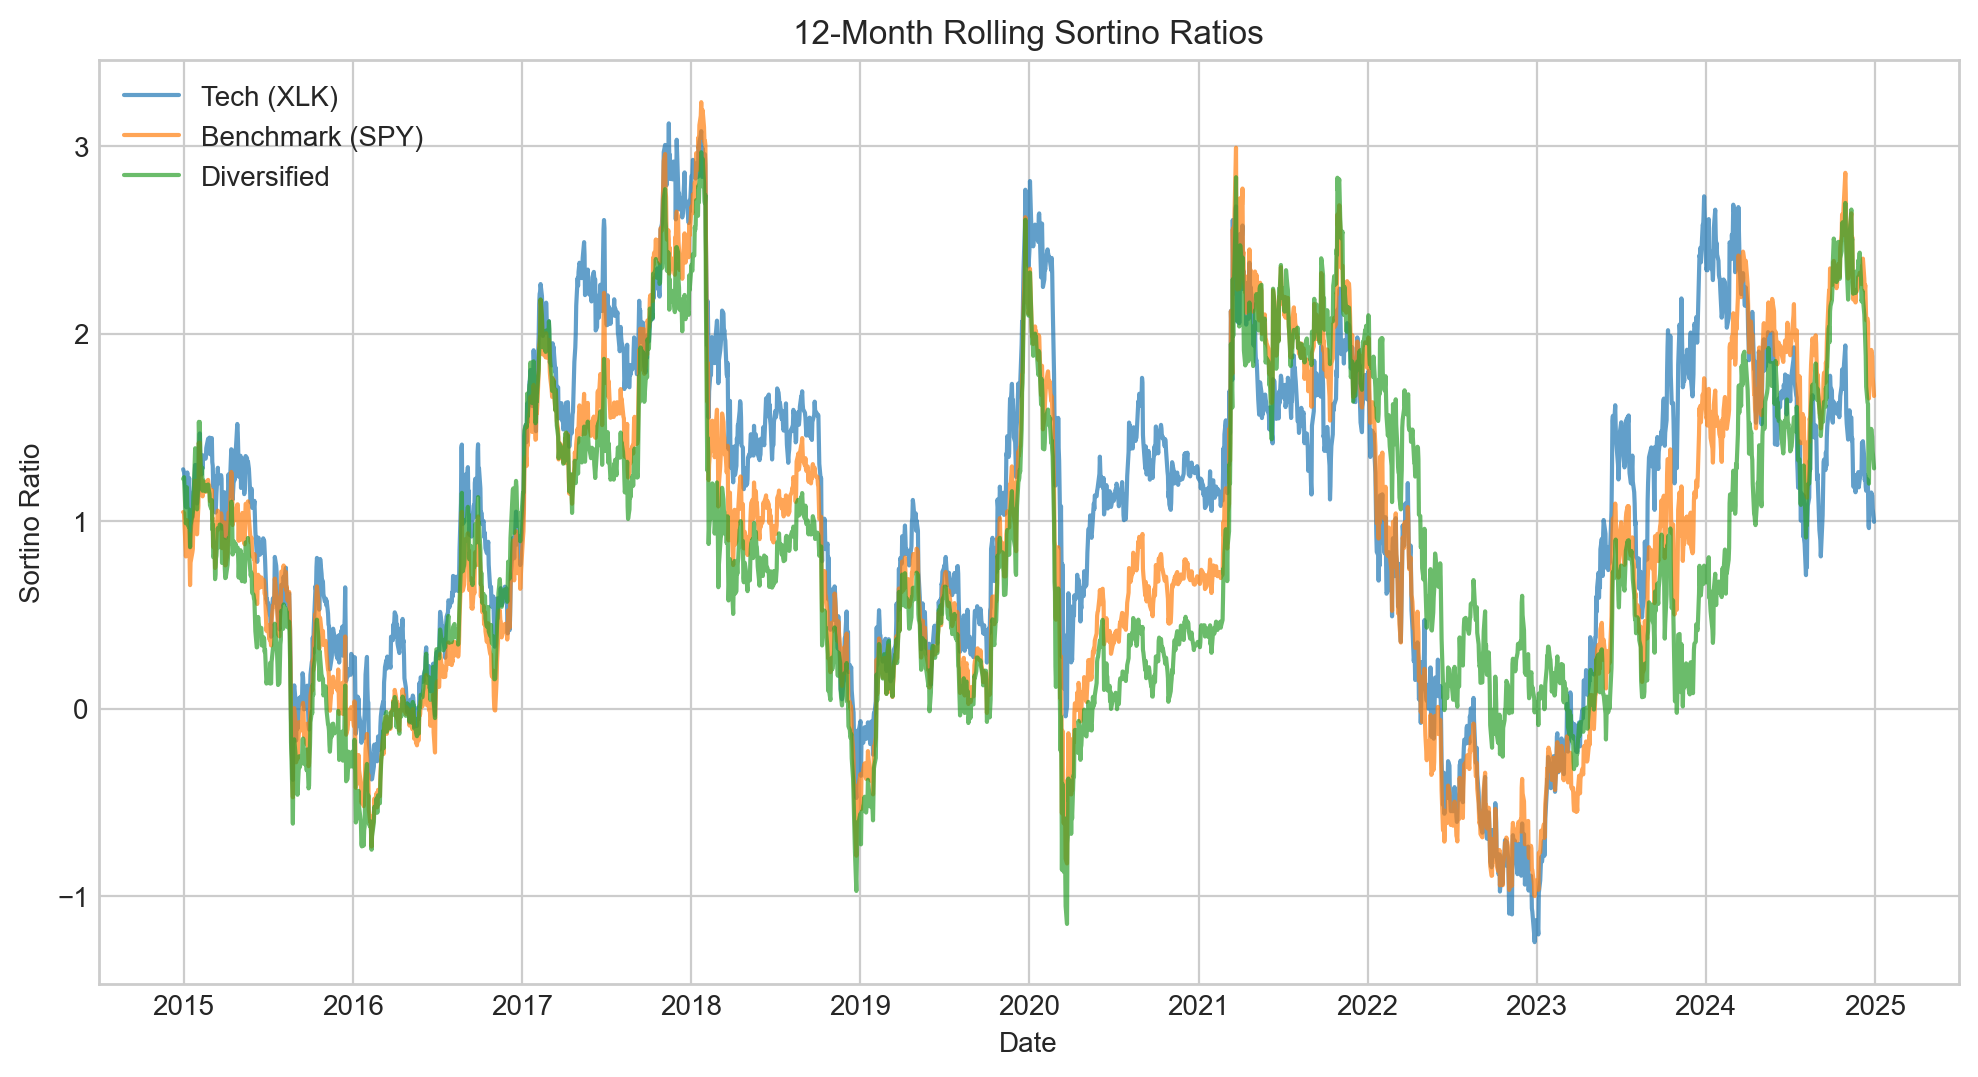

In [18]:
#rolling Sortino Ratios calculations
tech_rolling_downside_deviation = tech_rolling_returns.apply(lambda x: downside_deviation(x, MAR))
bench_rolling_downside_deviation = bench_rolling_returns.apply(lambda x: downside_deviation(x, MAR))
div_rolling_downside_deviation = div_rolling_returns.apply(lambda x: downside_deviation(x, MAR))

tech_rolling_sortino = (tech_rolling_returns.mean()*252 - average_tnx_yield)/(tech_rolling_downside_deviation * np.sqrt(252))
bench_rolling_sortino = (bench_returns.rolling(window = 252).mean()*252 - average_tnx_yield)/(bench_rolling_downside_deviation * np.sqrt(252))
div_rolling_sortino = (div_returns.rolling(window = 252).mean()*252 - average_tnx_yield)/(div_rolling_downside_deviation * np.sqrt(252))

plt.plot(tech_rolling_sortino, label='Tech (XLK)', alpha=0.7)
plt.plot(bench_rolling_sortino, label='Benchmark (SPY)', alpha=0.7)
plt.plot(div_rolling_sortino, label='Diversified', alpha=0.7)
plt.title('12-Month Rolling Sortino Ratios')
plt.ylabel('Sortino Ratio')
plt.xlabel('Date')
plt.legend()
plt.show()

The similarity between the rolling Sharpe and Sortino ratios indicates that the risk profile of these ETFs is predominantly characterized by downside risk. This supports the visual evidence from the drawdown charts, showing that these investments are primarily exposed to losses during market declines rather than benefiting from extreme positive volatility.

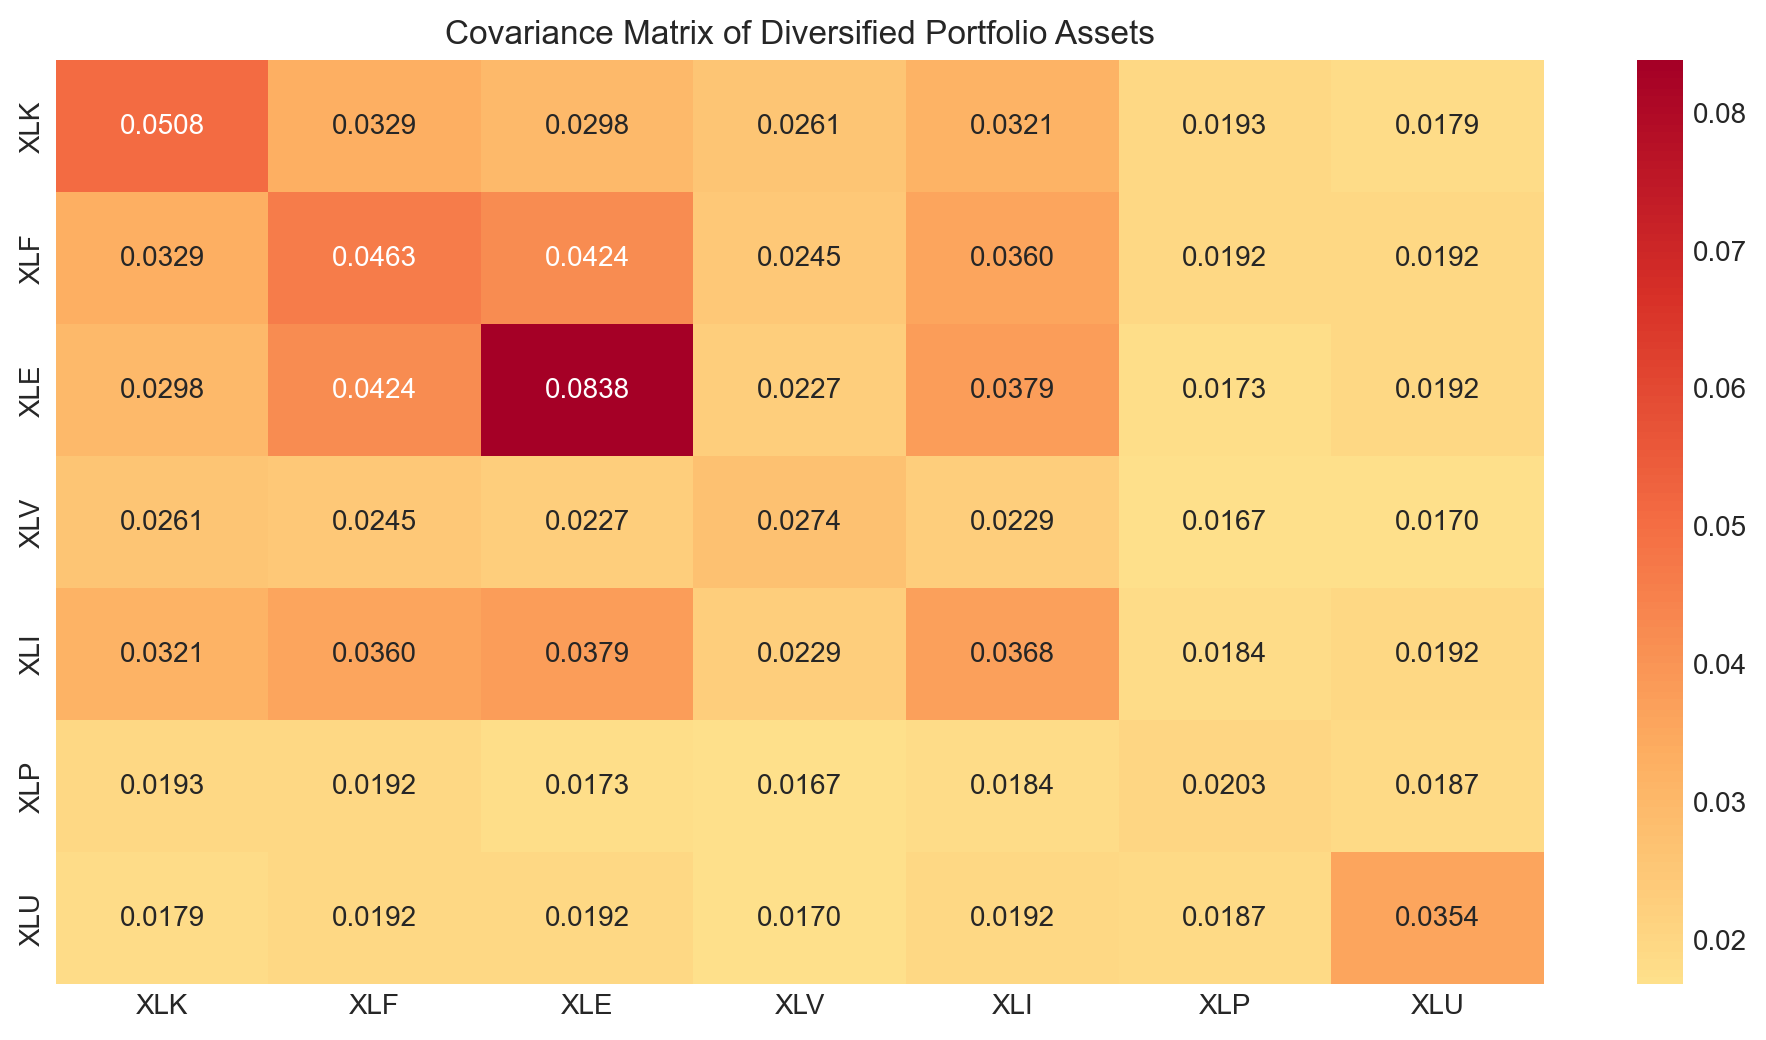

In [19]:
covariance_matrix = returns_df[div_tickers].cov()*252
sns.heatmap(covariance_matrix, 
            annot=True,
            fmt='.4f',
            cmap='RdYlGn_r',
            center=0)
plt.title('Covariance Matrix of Diversified Portfolio Assets')
plt.show()

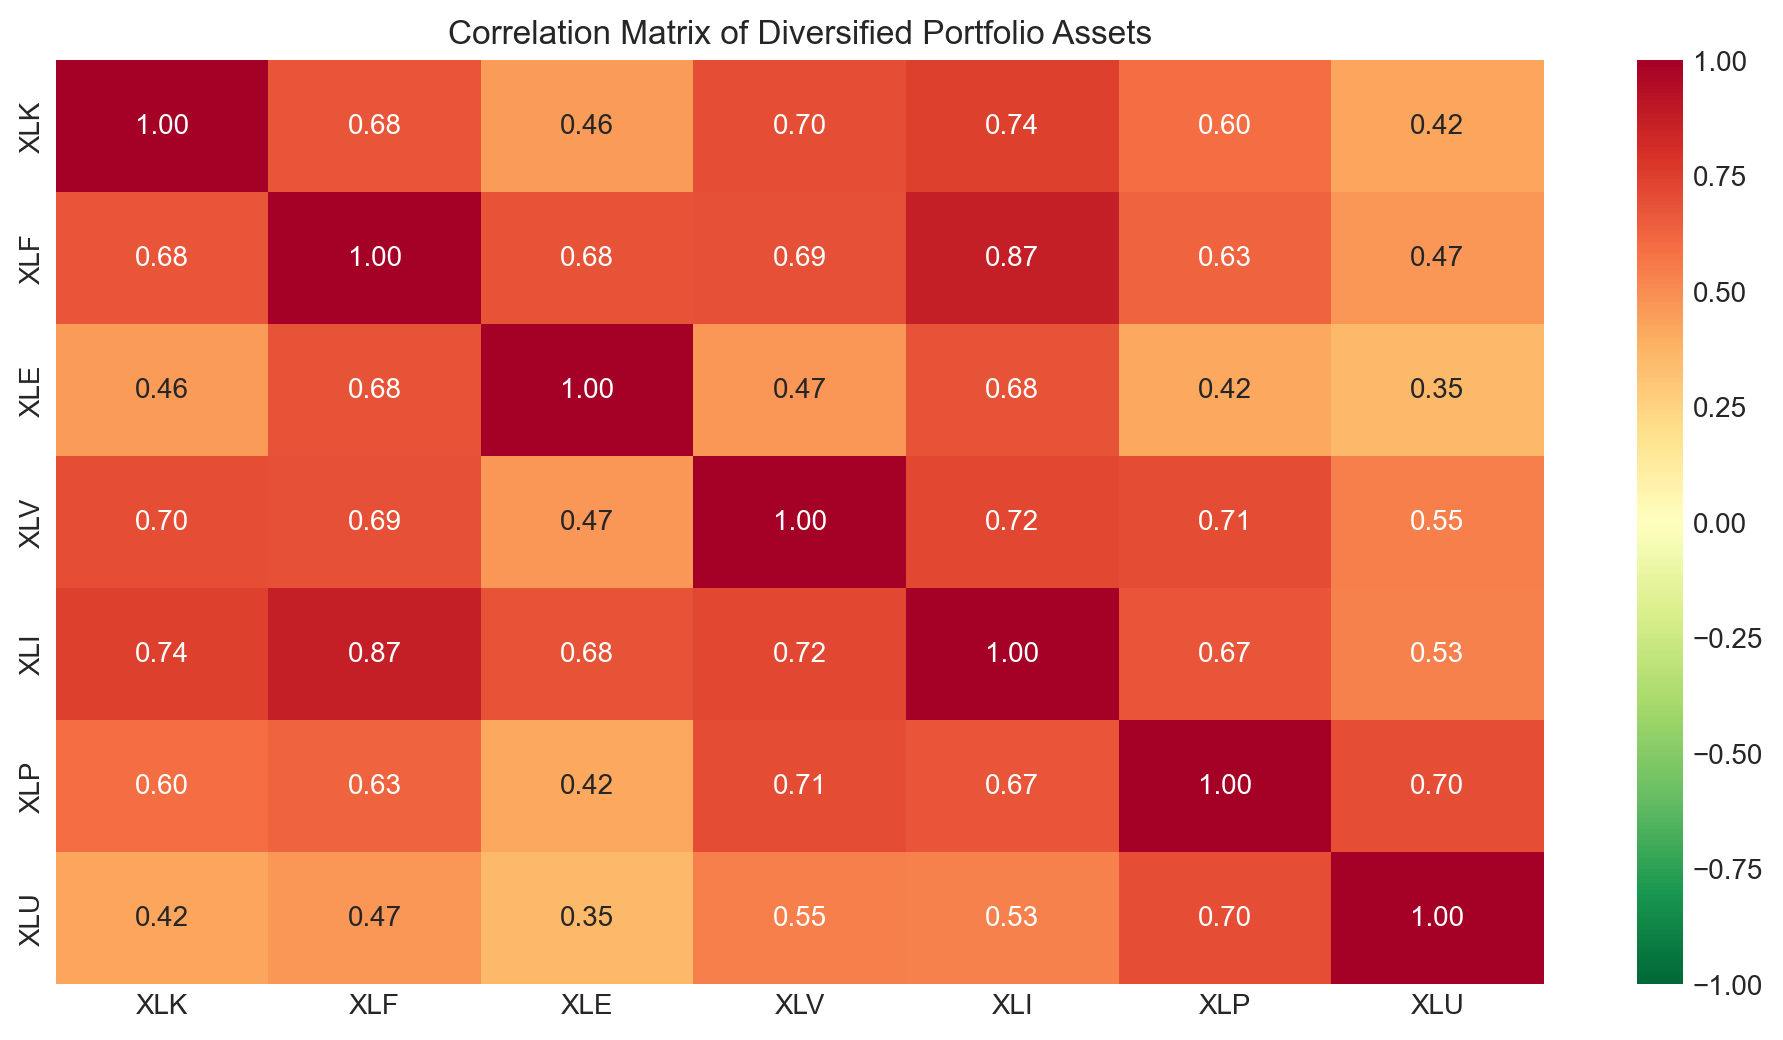

In [20]:
correlation_matrix = returns_df[div_tickers].corr()
sns.heatmap(correlation_matrix, 
            annot=True,
            fmt='.2f',
            cmap='RdYlGn_r',
            center=0,
            vmin=-1,
            vmax=1)
plt.title('Correlation Matrix of Diversified Portfolio Assets')
plt.show()

In [113]:
#efficient frontier calculations
ef_expected_returns = returns_df[div_tickers].mean() * 252
np.random.seed(41)
num_port = 50000
ef_all_weights_arr = np.zeros((num_port, len(div_tickers)))
ef_returns_arr = np.zeros(num_port)
ef_vol_arr = np.zeros(num_port)
ef_sharpe_arr = np.zeros(num_port)

for i in range(num_port):
    ef_weights = np.random.random(len(div_tickers))
    ef_weights /= np.sum(ef_weights)
    
    ef_all_weights_arr[i,:] = ef_weights
    ef_returns_arr[i] = np.sum(np.multiply(ef_expected_returns, ef_weights))
    ef_vol_arr[i] = np.sqrt(np.dot(ef_weights.T, np.dot(covariance_matrix, ef_weights)))
    ef_sharpe_arr[i] = (ef_returns_arr[i] - average_tnx_yield)/ef_vol_arr[i]

Max Sharpe Ratio for diversified portfolios: 0.806634950496735
Target weights for achieving max Sharpe Ratio in the diversified portfolio: 


TypeError: 'int' object is not iterable

In [116]:
print('Max Sharpe Ratio for diversified portfolios: {}'.format(ef_sharpe_arr.max()))
print('Target weights for achieving max Sharpe Ratio in the diversified portfolio: ')
for i in range(len(div_tickers)):
    print(f'{div_tickers[i]} {ef_all_weights_arr[ef_sharpe_arr.argmax(),i]:.2}')

Max Sharpe Ratio for diversified portfolios: 0.806634950496735
Target weights for achieving max Sharpe Ratio in the diversified portfolio: 
XLK 0.57
XLF 0.035
XLE 0.0052
XLV 0.043
XLI 0.045
XLP 0.083
XLU 0.22


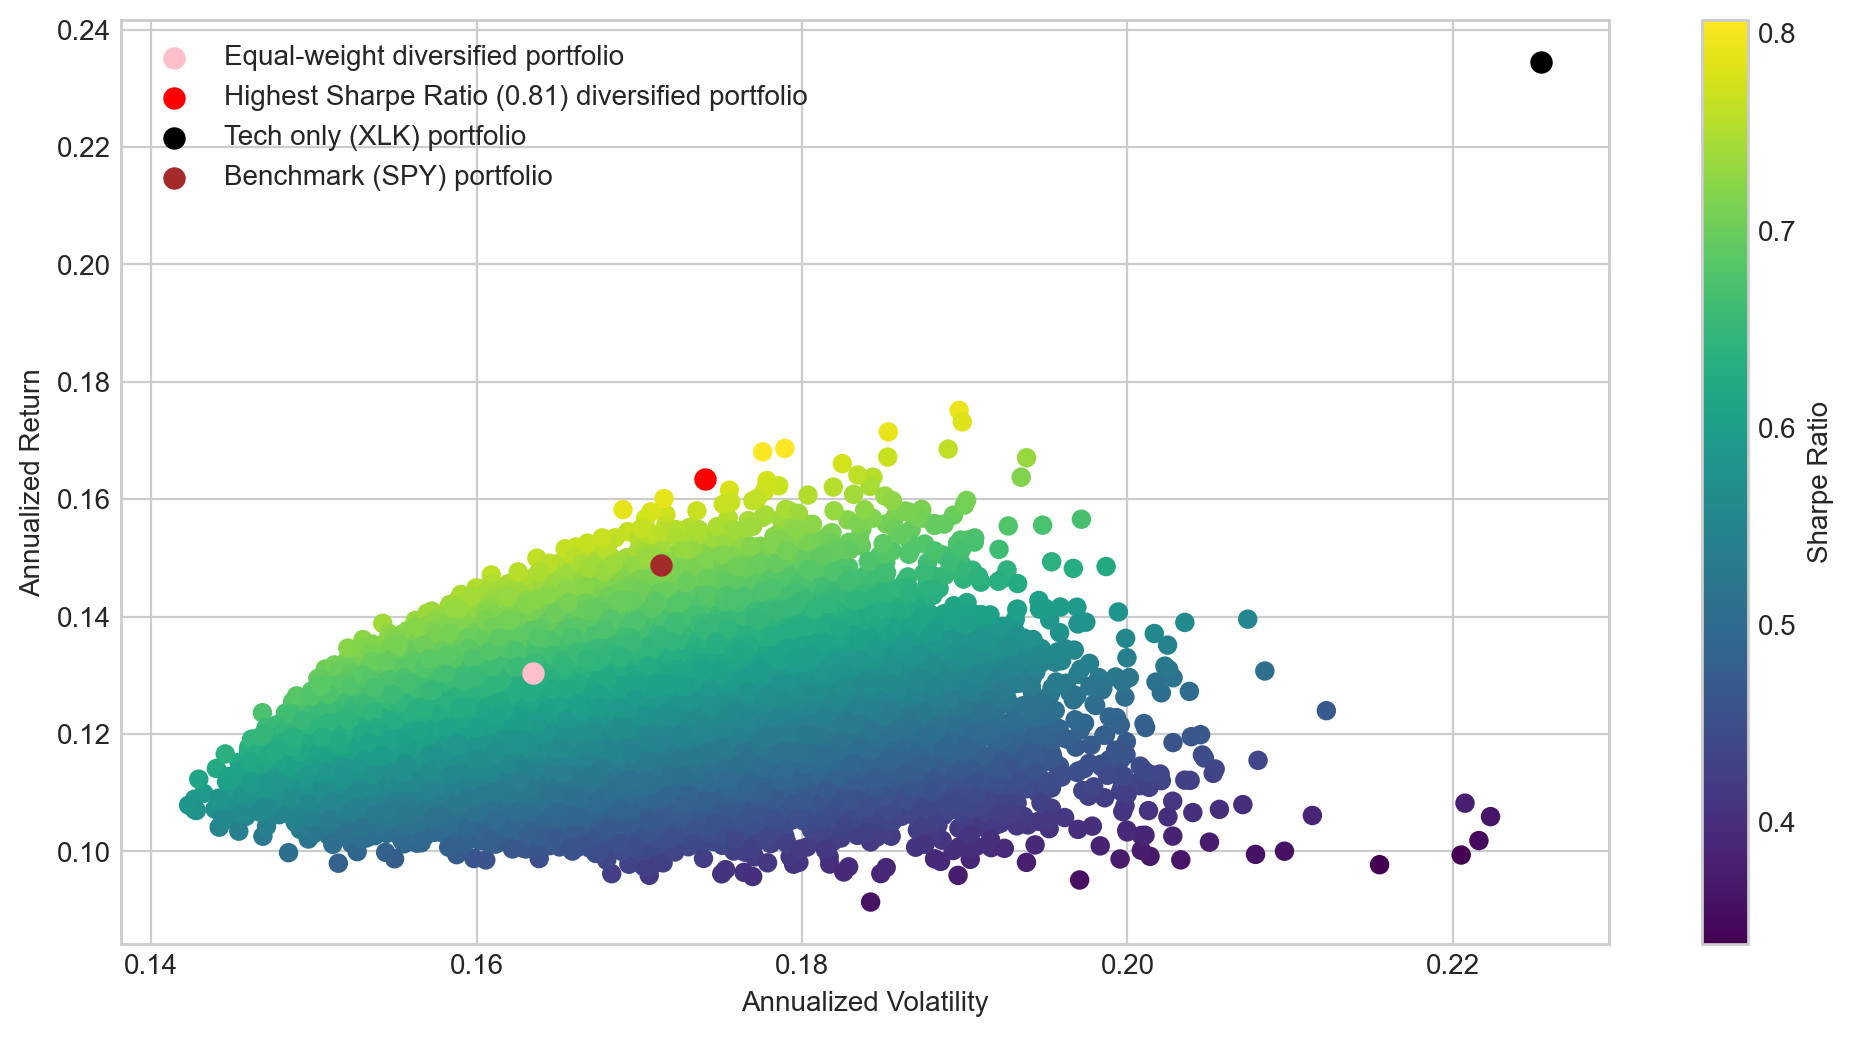

In [117]:
plt.scatter(ef_vol_arr, ef_returns_arr, c = ef_sharpe_arr, cmap = 'viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.scatter(div_annual_volatility, div_annualized_return, c = "pink", s = 50, label = 'Equal-weight diversified portfolio')
plt.scatter(max_sr_vol, max_sr_returns,c = 'red', s = 50, label = 'Highest Sharpe Ratio (0.81) diversified portfolio')
plt.scatter(tech_annual_volatility, tech_annualized_return, c = "black", s = 50, label = 'Tech only (XLK) portfolio')
plt.scatter(bench_annual_volatility, bench_annualized_return, c = "brown", s = 50, label = 'Benchmark (SPY) portfolio')
plt.legend()
plt.show()